# Loading RDKit mols

This tutorial shows how to load the conformers as RDKit `mol` objects. Using RDKit `mol` objects allows you to use RDKit modules to perform analysis on the conformers and generate hand-crafted 3D descriptors. This tutorial assumes that you are familiar with the first tutorial, `01_loading_data.ipynb`, which explains the data structure of the molecule dictionaries.



## Data organization

The RDKit information is contained in the folder `rdkit_folder.tar.gz`. After untarring the folder you will see the files `summary_drugs.json` and `summary_qm9.json`. These files contain all information about the different molecules, except for their individual conformers. 

The folders `qm9` and `drugs` contain individual pickle files for each molecule. Each of these pickle files contains information about all conformers for the given molecule. The conformer information is stored in the form of an RDKit `mol` object.

Because they don't store conformer information, the `summary` files are lightweight and can be easily loaded into memory. They can be used as a sort of directory to filter and choose species of interest. Once you have chosen the molecules you're interested in, you can load them individually through their individual pickle files. 

## Untarring the folder

To untar the RDKit folder, run 
```bash
tar -xzvf rdkit_folder.tar.gz
```

in the command line. This should generate a folder called `rdkit_folder`.

## Example: Choosing SARS-CoV 3CL active molecules

Let's say we're interested in quickly training a model to predict SARS-CoV 3CL inhibition. We may want to use all positive binders (of which there are only a few hundred), but only a subset of negative binders (of which there are hundreds of thousands). To do so, let's first find the molecules we're interested in by loading the `drugs` summary file:

In [1]:
import os
import json
import random
import pickle

drugs_file = "rdkit_folder/summary_drugs.json"

with open(drugs_file, "r") as f:
    drugs_summ = json.load(f)

Each item in the `drugs_summ` dictionary contains summary information as well as the path to the corresponding pickle file (`pickle_path`). (The pickle paths are generally just `drugs/<smiles>.pickle` or `qm9/<smiles>.pickle`, where `<smiles>` is the SMILES string with `/` replaced by `_`. However, there are a couple of exceptions for SMILES strings that are too large to be file names.) 

Here's an example:

In [2]:
example_smiles = list(drugs_summ.keys())[0]
print(example_smiles)
drugs_summ[example_smiles]

BrC(/C=C\c1ccccc1)=N/Nc1nc(N2CCOCC2)nc(N2CCOCC2)n1


{'charge': 0,
 'datasets': ['plpro', 'aid1706'],
 'ensembleenergy': 0.282,
 'ensembleentropy': 7.264,
 'ensemblefreeenergy': -2.166,
 'lowestenergy': -87.80248,
 'pickle_path': 'drugs/BrC(_C=C\\c1ccccc1)=N_Nc1nc(N2CCOCC2)nc(N2CCOCC2)n1.pickle',
 'poplowestpct': 46.745,
 'sars_cov_one_cl_protease_active': 0,
 'sars_cov_one_pl_protease_active': 0,
 'temperature': 298.15,
 'totalconfs': 83,
 'uniqueconfs': 27}

For an in-depth description of the dictionary keys, see the tutorial `01_loading_data.ipynb`.

Now let's find our active molecules and their pickle paths:

In [3]:
active_mol_paths = []

for smiles, sub_dic in drugs_summ.items():
    
    # only select active molecules
    
    if sub_dic.get("sars_cov_one_cl_protease_active") == 1:
        pickle_path = os.path.join("rdkit_folder", sub_dic.get("pickle_path", ""))
        if os.path.isfile(pickle_path):
            active_mol_paths.append(pickle_path)

print(len(active_mol_paths))


411


Now let's find ~2000 random inactive molecules:


In [4]:
# randomly sample the smiles

random_smiles = list(drugs_summ.keys())
random.shuffle(random_smiles)
random_smiles = random_smiles[:2200]

inactive_mol_paths = []


for smiles in random_smiles:
    
    sub_dic = drugs_summ[smiles]
    
    # only select inactive molecules

    if sub_dic.get("sars_cov_one_cl_protease_active") == 0:
        # add the prefix "rdkit_folder" to the path
        pickle_path = os.path.join("rdkit_folder", sub_dic.get("pickle_path", ""))
        # check if the path exists
        if os.path.isfile(pickle_path):
            inactive_mol_paths.append(pickle_path)

print(len(inactive_mol_paths))



2050


Finally, let's load all these pickle files into one dictionary:

In [5]:
sample_dic = {}
for mol_path in [*active_mol_paths, *inactive_mol_paths]:
    with open(mol_path, "rb") as f:
        dic = pickle.load(f)
        
    # set the keys of the new dictionary to
    # be SMILES strings
    sample_dic.update({dic["smiles"]: dic})
    
print(len(sample_dic))

2461


Here's an example of one of our dictionary items:

In [6]:
sample_smiles = list(sample_dic.keys())[0]
sample_dic[sample_smiles]

{'conformers': [{'geom_id': 86429709,
   'set': 1,
   'degeneracy': 6,
   'totalenergy': -74.93380308,
   'relativeenergy': 0.0,
   'boltzmannweight': 0.51989,
   'conformerweights': [0.08671, 0.0867, 0.0867, 0.08667, 0.08664, 0.08647],
   'rd_mol': <rdkit.Chem.rdchem.Mol at 0x7f1273a8e6b0>},
  {'geom_id': 86429710,
   'set': 2,
   'degeneracy': 6,
   'totalenergy': -74.93355597,
   'relativeenergy': 0.155,
   'boltzmannweight': 0.4003,
   'conformerweights': [0.06676, 0.06674, 0.06673, 0.06672, 0.06671, 0.06664],
   'rd_mol': <rdkit.Chem.rdchem.Mol at 0x7f1211cb5cf0>},
  {'geom_id': 86429711,
   'set': 3,
   'degeneracy': 6,
   'totalenergy': -74.93120196,
   'relativeenergy': 1.632,
   'boltzmannweight': 0.03312,
   'conformerweights': [0.00553, 0.00553, 0.00552, 0.00552, 0.00552, 0.00551],
   'rd_mol': <rdkit.Chem.rdchem.Mol at 0x7f1249977170>},
  {'geom_id': 86429712,
   'set': 4,
   'degeneracy': 4,
   'totalenergy': -74.93112832,
   'relativeenergy': 1.678,
   'boltzmannweight': 

For an in-depth description of the dictionary keys, see the tutorial `01_loading_data.ipynb`.

## Performing analysis with RDKit

Having molecules available as RDKit objects allows us to perform all sorts of analysis, from visualization to generating descriptors. Let's look at a few examples.

First, we can easily visualize different conformers:

Boltzmann weight: 0.51989
Degeneracy: 6
Relative energy: 0.0


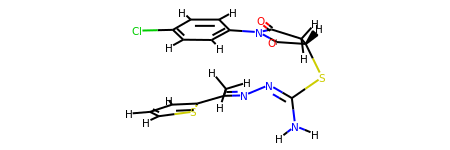

Boltzmann weight: 0.4003
Degeneracy: 6
Relative energy: 0.155


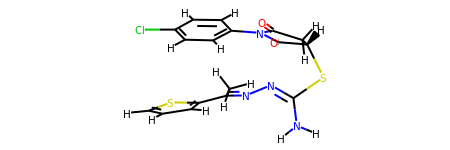

Boltzmann weight: 0.03312
Degeneracy: 6
Relative energy: 1.632


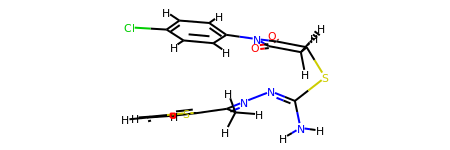

Boltzmann weight: 0.02044
Degeneracy: 4
Relative energy: 1.678


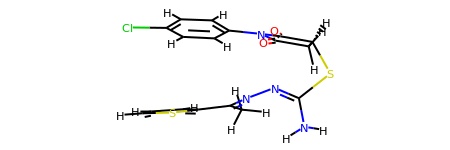

Boltzmann weight: 0.00728
Degeneracy: 3
Relative energy: 2.119


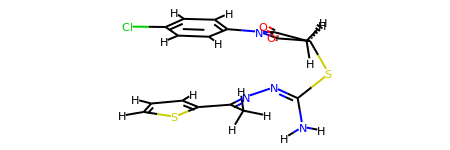

Boltzmann weight: 0.00242
Degeneracy: 1
Relative energy: 2.122


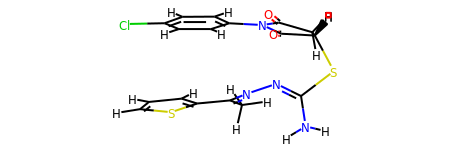

Boltzmann weight: 0.01308
Degeneracy: 6
Relative energy: 2.183


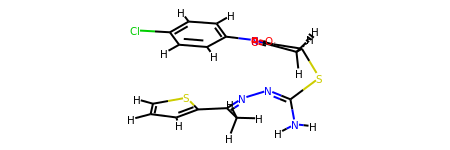

Boltzmann weight: 0.00041
Degeneracy: 1
Relative energy: 3.168


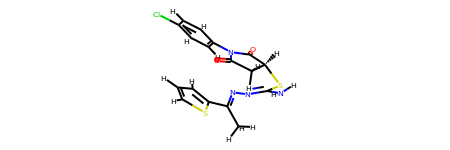

Boltzmann weight: 0.00028
Degeneracy: 1
Relative energy: 3.405


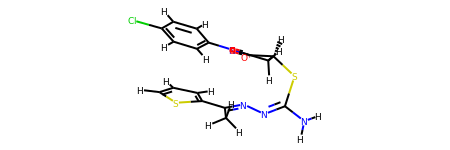

Boltzmann weight: 0.00017
Degeneracy: 1
Relative energy: 3.708


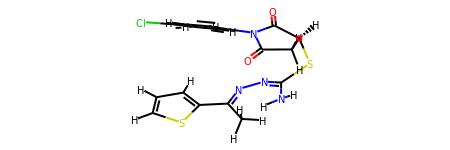

Boltzmann weight: 0.00016
Degeneracy: 1
Relative energy: 3.735


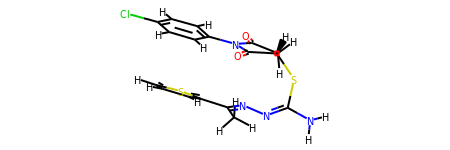

Boltzmann weight: 0.00041
Degeneracy: 3
Relative energy: 3.822


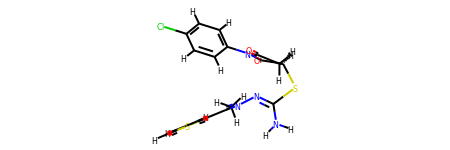

Boltzmann weight: 0.00014
Degeneracy: 1
Relative energy: 3.829


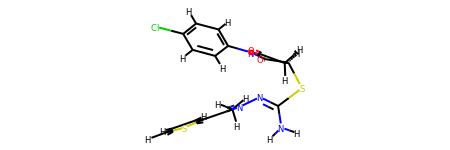

Boltzmann weight: 0.00038
Degeneracy: 3
Relative energy: 3.875


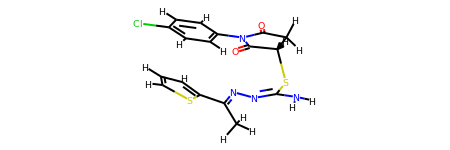

Boltzmann weight: 0.00011
Degeneracy: 1
Relative energy: 3.971


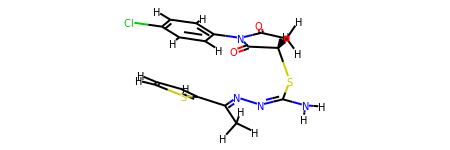

Boltzmann weight: 0.0002
Degeneracy: 2
Relative energy: 4.02


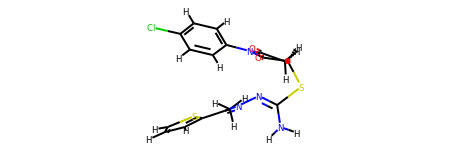

Boltzmann weight: 0.0001
Degeneracy: 1
Relative energy: 4.031


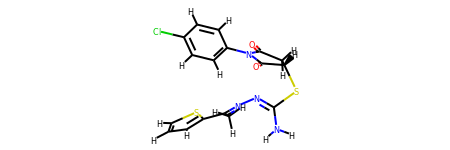

Boltzmann weight: 9e-05
Degeneracy: 1
Relative energy: 4.059


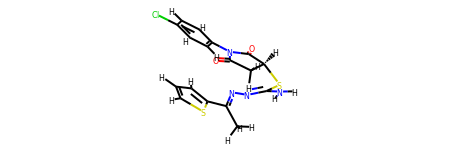

Boltzmann weight: 9e-05
Degeneracy: 1
Relative energy: 4.087


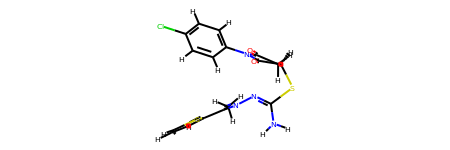

Boltzmann weight: 8e-05
Degeneracy: 1
Relative energy: 4.142


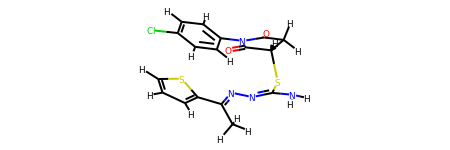

Boltzmann weight: 8e-05
Degeneracy: 1
Relative energy: 4.178


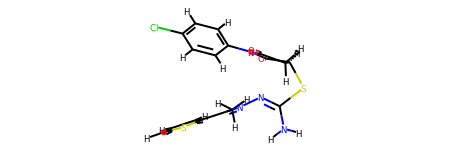

Boltzmann weight: 7e-05
Degeneracy: 1
Relative energy: 4.222


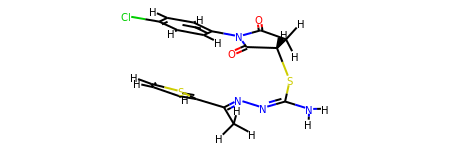

Boltzmann weight: 0.00014
Degeneracy: 2
Relative energy: 4.227


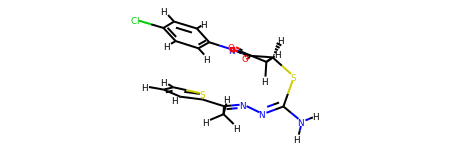

Boltzmann weight: 7e-05
Degeneracy: 1
Relative energy: 4.229


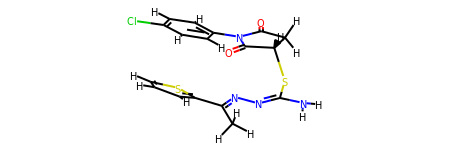

Boltzmann weight: 6e-05
Degeneracy: 1
Relative energy: 4.297


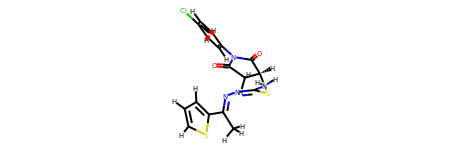

Boltzmann weight: 6e-05
Degeneracy: 1
Relative energy: 4.299


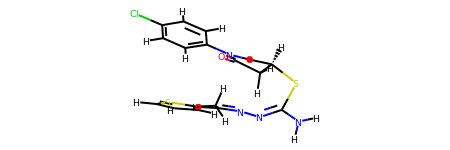

Boltzmann weight: 0.00012
Degeneracy: 2
Relative energy: 4.317


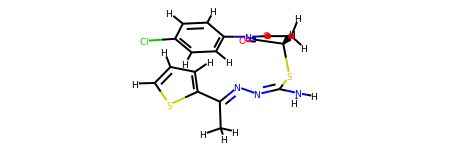

Boltzmann weight: 6e-05
Degeneracy: 1
Relative energy: 4.328


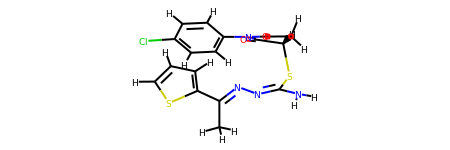

Boltzmann weight: 9e-05
Degeneracy: 2
Relative energy: 4.478


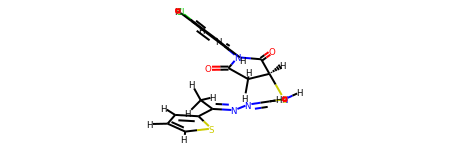

Boltzmann weight: 4e-05
Degeneracy: 1
Relative energy: 4.599


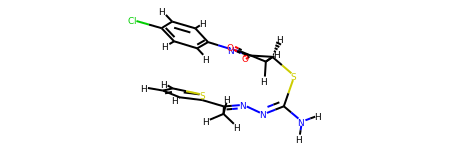

Boltzmann weight: 4e-05
Degeneracy: 2
Relative energy: 4.915


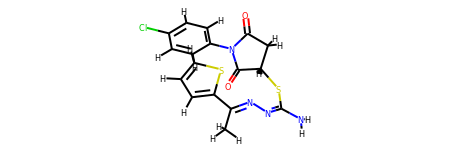

Boltzmann weight: 1e-05
Degeneracy: 1
Relative energy: 5.498


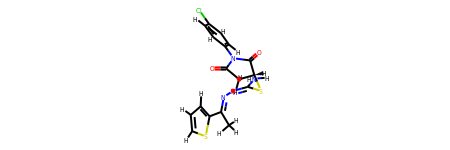

Boltzmann weight: 1e-05
Degeneracy: 2
Relative energy: 5.763


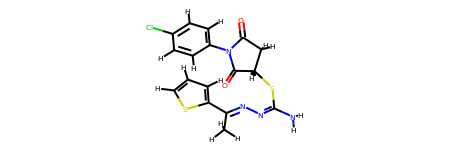

Boltzmann weight: 0.0
Degeneracy: 1
Relative energy: 5.79


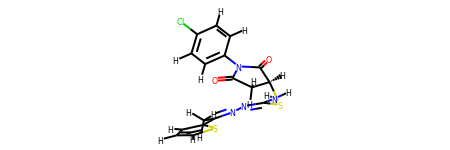

In [20]:
from IPython.display import display

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdMolDescriptors import CalcWHIM
from rdkit.Chem.rdmolfiles import MolToPDBFile
from e3fp.pipeline import fprints_from_mol

from matplotlib import pyplot as plt
import numpy as np

confs = sample_dic[sample_smiles]['conformers']

for conf in confs:
    mol = conf['rd_mol']
    weight = conf["boltzmannweight"]
    degen = conf["degeneracy"]
    en = conf["relativeenergy"]
    
    print(f"Boltzmann weight: {weight}")
    print(f"Degeneracy: {degen}")
    print(f"Relative energy: {en}")
    display(mol)

You can also rotate the conformers to maximize their overlap. This makes it easier to see how they differ:

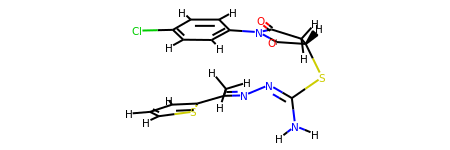

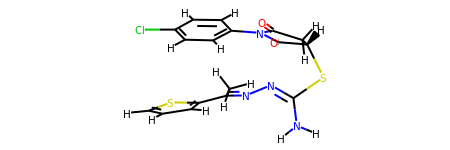

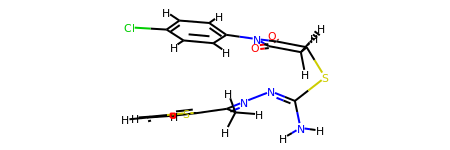

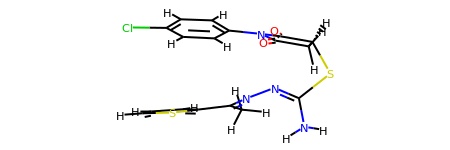

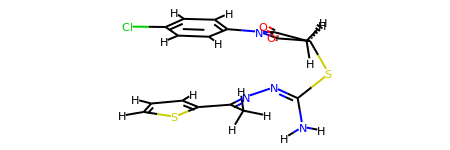

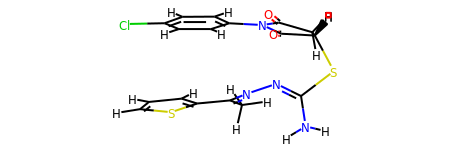

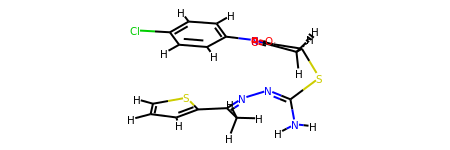

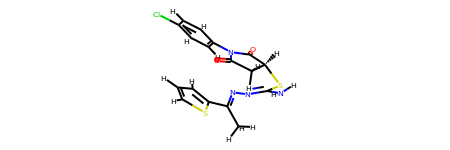

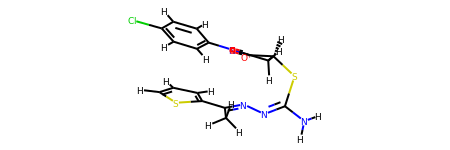

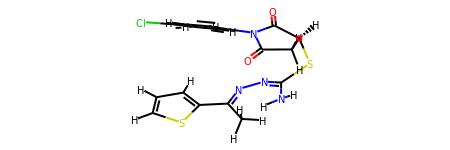

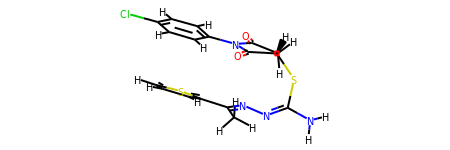

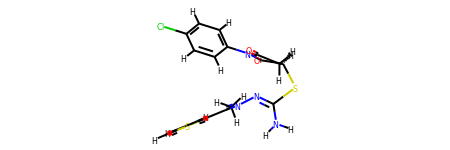

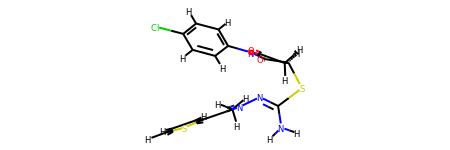

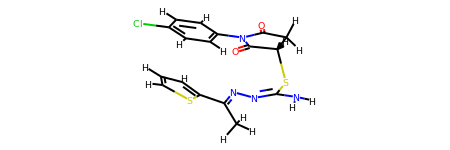

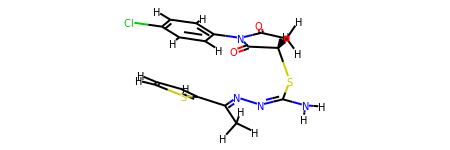

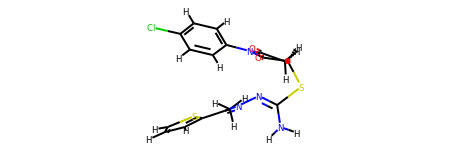

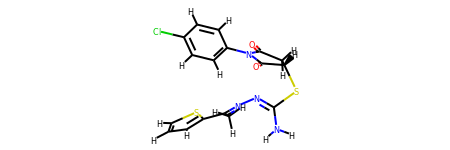

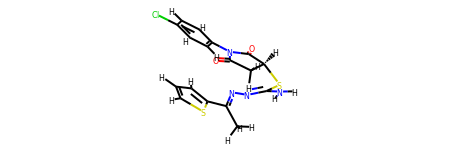

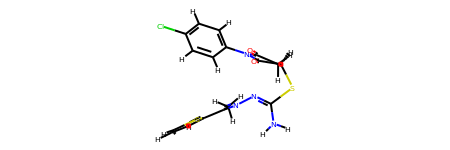

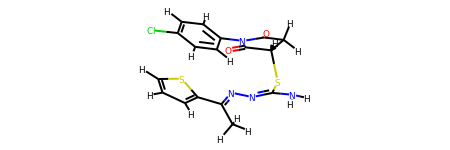

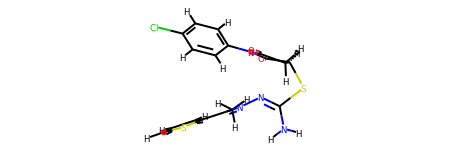

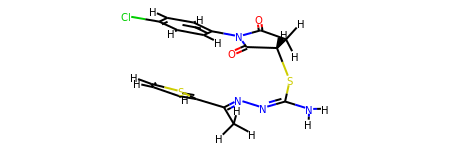

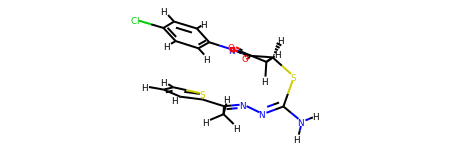

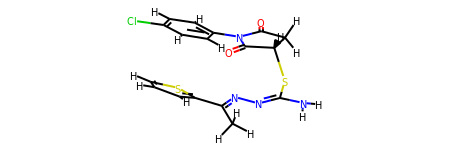

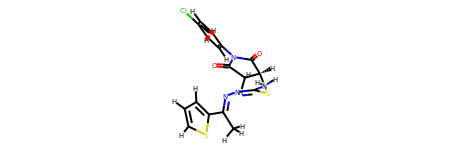

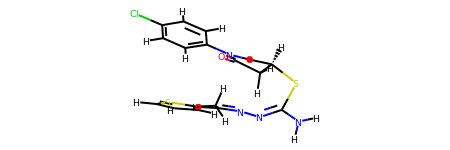

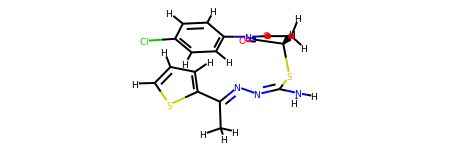

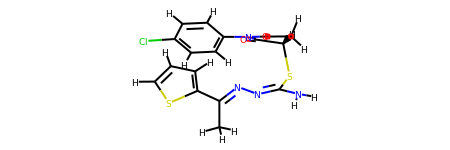

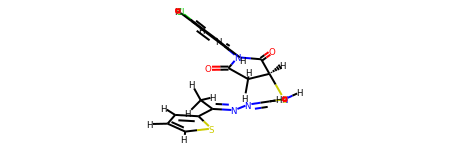

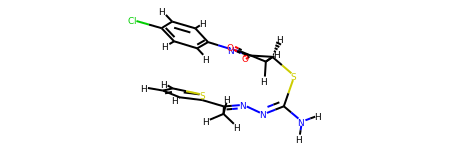

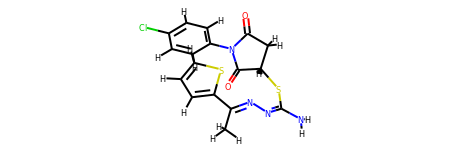

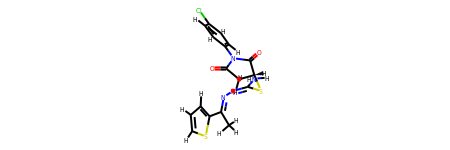

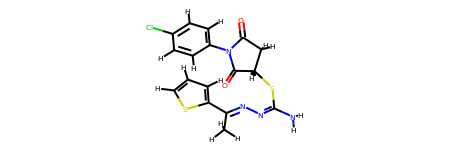

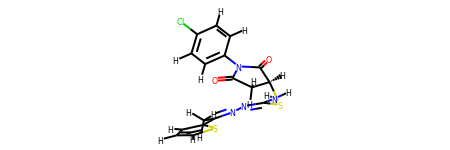

In [8]:
rd_mols = [conf['rd_mol'] for conf in confs]

for i, mol in enumerate(rd_mols[1:]):
    # align the mol to maximiz overlap with the first one
    Chem.rdMolAlign.AlignMol(prbMol=mol, refMol=rd_mols[0])
    rd_mols[i+1] = mol
for mol in rd_mols:
    display(mol)

Note that because every CREST conformer gets its own `mol` object, every `mol` object has only one RDKit conformer:

In [9]:
print(confs[0]["rd_mol"].GetConformers())
print(confs[1]["rd_mol"].GetConformers())

(<rdkit.Chem.rdchem.Conformer object at 0x7f1239ff0990>,)
(<rdkit.Chem.rdchem.Conformer object at 0x7f1239ff0990>,)


Next, we can generated 2D and 3D descriptors. The Morgan fingerprint of each conformer should be identical, unless different conformers have different connectivities:

In [10]:
morgan_fps = []
for conf in confs:
    rd_mol = conf["rd_mol"]
    fp = AllChem.GetMorganFingerprintAsBitVect(rd_mol, 2, nBits=1024)
    morgan_fps.append(fp)

# the Morgan fingerprints should be the same unless
# connectivity has changed
all([fp == morgan_fps[0] for fp in morgan_fps])

True

On the other hand, 3D descriptors will generally be different. For example, let's look at the WHIM descriptor and the E3FP descriptors:

2020-06-18 11:36:01,657|INFO|Generating fingerprints for conf_0.
2020-06-18 11:36:01,764|INFO|Generated 1 fingerprints for conf_0.
2020-06-18 11:36:01,765|INFO|Generating fingerprints for conf_1.
2020-06-18 11:36:01,848|INFO|Generated 1 fingerprints for conf_1.
2020-06-18 11:36:01,850|INFO|Generating fingerprints for conf_2.
2020-06-18 11:36:01,933|INFO|Generated 1 fingerprints for conf_2.
2020-06-18 11:36:01,935|INFO|Generating fingerprints for conf_3.
2020-06-18 11:36:02,019|INFO|Generated 1 fingerprints for conf_3.
2020-06-18 11:36:02,020|INFO|Generating fingerprints for conf_4.
2020-06-18 11:36:02,126|INFO|Generated 1 fingerprints for conf_4.
2020-06-18 11:36:02,128|INFO|Generating fingerprints for conf_5.
2020-06-18 11:36:02,214|INFO|Generated 1 fingerprints for conf_5.
2020-06-18 11:36:02,215|INFO|Generating fingerprints for conf_6.
2020-06-18 11:36:02,301|INFO|Generated 1 fingerprints for conf_6.
2020-06-18 11:36:02,302|INFO|Generating fingerprints for conf_7.
2020-06-18 11:36:0

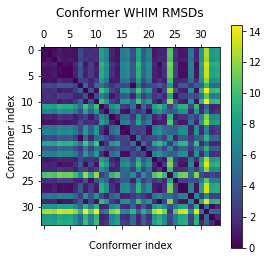

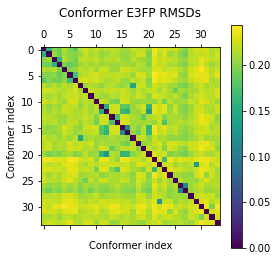

In [56]:
import warnings
warnings.filterwarnings('ignore')

whims = []
e3fps = []

for i, conf in enumerate(confs):
    rd_mol = conf["rd_mol"]
    whim = np.array(CalcWHIM(rd_mol))
    whims.append(whim)
    
    # e3fp mols must have names
    
    rd_mol.SetProp("_Name", "conf_{}".format(i))
    fprint_params = {"bits": 1024}
    fp = fprints_from_mol(rd_mol, fprint_params=fprint_params);
    fp_as_vec = fp[0].to_bitvector()
    e3fps.append(fp_as_vec.toarray().astype('int'))


# calculate the RMSDs between the vectors

whim_rmsds = np.zeros((len(whims), len(whims)))
e3fp_rmsds = np.zeros((len(whims), len(whims)))


for i in range(len(whims)):
    for j in range(len(whims)):
        whim_rmsd = np.mean((whims[i] - whims[j]) ** 2) ** 0.5
        whim_rmsds[i, j] = whim_rmsd
   
        e3fp_rmsd = np.mean((e3fps[i] - e3fps[j]) ** 2) ** 0.5
        e3fp_rmsds[i, j] = e3fp_rmsd
        
# see how similar the descriptors of the conformers are 

plt.matshow(whim_rmsds)
plt.colorbar()
plt.xlabel("\nConformer index")
plt.ylabel("Conformer index")
plt.title("Conformer WHIM RMSDs\n")
plt.show()

plt.matshow(e3fp_rmsds)
plt.colorbar()
plt.xlabel("\nConformer index")
plt.ylabel("Conformer index")
plt.title("Conformer E3FP RMSDs\n")
plt.show()

We can see a summary of the molecule using `Chem.MolToMolBlock`:

In [12]:
print(Chem.MolToMolBlock(confs[0]["rd_mol"]))


     RDKit          3D

 41 43  0  0  0  0  0  0  0  0999 V2000
   -0.2180   -1.1276    2.1985 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.3125   -1.4587    0.7398 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.6535   -1.4378   -0.1002 N   0  0  0  0  0  0  0  0  0  0  0  0
    1.8602   -0.9337    0.1723 N   0  0  0  0  0  0  0  0  0  0  0  0
    2.9457   -1.5671    0.3408 C   0  0  0  0  0  0  0  0  0  0  0  0
    3.1069   -2.9072    0.5211 N   0  0  0  0  0  0  0  0  0  0  0  0
    4.0357   -3.2842    0.4374 H   0  0  0  0  0  0  0  0  0  0  0  0
    2.3484   -3.4966    0.2142 H   0  0  0  0  0  0  0  0  0  0  0  0
    4.3964   -0.5685    0.4348 S   0  0  0  0  0  0  0  0  0  0  0  0
    3.6127    1.0283    0.0471 C   0  0  2  0  0  0  0  0  0  0  0  0
    2.2176    1.1243    0.6704 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.9772    1.1222    1.8516 O   0  0  0  0  0  0  0  0  0  0  0  0
    1.3564    1.5986   -0.3351 N   0  0  0  0  0  0  0  0  0  0  0  0
    1.9625    1.7301   -1

We can extract the `xyz`:


In [13]:
rd_mol = confs[0]["rd_mol"]
atoms = rd_mol.GetAtoms()

# get the atomic numbers

atom_nums = []
for atom in atoms:
    atom_nums.append(atom.GetAtomicNum())

# get the coordinates

rd_conf = rd_mol.GetConformers()[0]
positions = rd_conf.GetPositions()

xyz = []
for atom_num, position in zip(atom_nums, positions):
    xyz.append([atom_num, *position])

# convert to numpy array
xyz = np.array(xyz)

xyz

array([[ 6.        , -0.2180364 , -1.12756598,  2.19850445],
       [ 6.        , -0.31246442, -1.45867693,  0.73981404],
       [ 7.        ,  0.65347183, -1.43775094, -0.1001703 ],
       [ 7.        ,  1.86018813, -0.93373644,  0.17233974],
       [ 6.        ,  2.94574118, -1.56708074,  0.34075454],
       [ 7.        ,  3.10687685, -2.907197  ,  0.52114409],
       [ 1.        ,  4.03570318, -3.28421378,  0.43741578],
       [ 1.        ,  2.34842634, -3.49656296,  0.21418644],
       [16.        ,  4.39644003, -0.56847727,  0.43478417],
       [ 6.        ,  3.61268091,  1.02832437,  0.04705635],
       [ 6.        ,  2.21763587,  1.12429762,  0.67035455],
       [ 8.        ,  1.97718728,  1.12215972,  1.85158944],
       [ 7.        ,  1.35635078,  1.59857202, -0.33514643],
       [ 6.        ,  1.96250618,  1.73014736, -1.56541061],
       [ 8.        ,  1.44072556,  2.15088773, -2.56293845],
       [ 6.        ,  3.40669751,  1.27932394, -1.43488228],
       [ 1.        ,  4.

And we can extract atom and bond features:

In [14]:
atom = atoms[3]
h_bonds = [bond for bond in atom.GetBonds()
            if any([bond.GetBeginAtom().GetAtomicNum()==1,
                    bond.GetEndAtom().GetAtomicNum()==1])]

atom_features = {"atom_type": atom.GetAtomicNum(), 
                "formal_charge": atom.GetFormalCharge(),
                "hybridization": atom.GetHybridization().name.lower(),
                "is_aromatic": atom.GetIsAromatic(),
                "num_bonds": len(atom.GetBonds()),
                "num_h_bonds": len(h_bonds),
                "chirality": atom.GetChiralTag().name.lower(),
                "mass": atom.GetMass()}

print("Some features of atom 3:")
display(atom_features)




bond = rd_mol.GetBonds()[24]
in_ring_size = -1
for size in range(10):
    if bond.IsInRingSize(size):
        in_ring_size = size
        
bond_features = {"indices": [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()],
                "type": bond.GetBondType().name.lower(),
                "stereo": bond.GetStereo().name.lower().split("stereo")[-1],
                "conjugated": bond.GetIsConjugated(),
                "in_ring": bond.IsInRing(),
                "in_ring_size": in_ring_size}

print("\n")
print("Some features of bond 24:")
display(bond_features)



Some features of atom 3:


{'atom_type': 7,
 'formal_charge': 0,
 'hybridization': 'sp2',
 'is_aromatic': False,
 'num_bonds': 2,
 'num_h_bonds': 0,
 'chirality': 'chi_unspecified',
 'mass': 14.007}



Some features of bond 24:


{'indices': [18, 19],
 'type': 'aromatic',
 'stereo': 'none',
 'conjugated': True,
 'in_ring': True,
 'in_ring_size': 6}

## Exporting to PDB

You may be interested in generating PDB files for the molecules, for example to perform docking. This can be done easily with RDKit:

In [15]:
MolToPDBFile(confs[0]["rd_mol"], "test.pdb")

Let's see what it looks like:

In [16]:
with open("test.pdb", "r") as f:
    pdb_text = f.read()
print(pdb_text)

HETATM    1  C1  UNL     1      -0.218  -1.128   2.199  1.00  0.00           C  
HETATM    2  C2  UNL     1      -0.312  -1.459   0.740  1.00  0.00           C  
HETATM    3  N1  UNL     1       0.653  -1.438  -0.100  1.00  0.00           N  
HETATM    4  N2  UNL     1       1.860  -0.934   0.172  1.00  0.00           N  
HETATM    5  C3  UNL     1       2.946  -1.567   0.341  1.00  0.00           C  
HETATM    6  N3  UNL     1       3.107  -2.907   0.521  1.00  0.00           N  
HETATM    7  H1  UNL     1       4.036  -3.284   0.437  1.00  0.00           H  
HETATM    8  H2  UNL     1       2.348  -3.497   0.214  1.00  0.00           H  
HETATM    9  S1  UNL     1       4.396  -0.568   0.435  1.00  0.00           S  
HETATM   10  C4  UNL     1       3.613   1.028   0.047  1.00  0.00           C  
HETATM   11  C5  UNL     1       2.218   1.124   0.670  1.00  0.00           C  
HETATM   12  O1  UNL     1       1.977   1.122   1.852  1.00  0.00           O  
HETATM   13  N4  UNL     1  